# Proyecto Analisis De Prediccion de Deserción Universitaria


1. Importación de las Librerías

2. Carga y exploración de Datos

In [4]:

import warnings, os
warnings.filterwarnings('ignore')

# ✅ Verificar si XGBoost está disponible
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ✅ Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    roc_auc_score, f1_score, precision_score, recall_score,
    brier_score_loss, roc_curve, confusion_matrix
)
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.calibration import calibration_curve

# %% DIRECTORIO DE RESULTADOS
# ------------------------------------------
# 📂 Crea una carpeta 'resultados' dentro del directorio actual
#    (funciona en GitHub Codespaces, VS Code, Google Colab o local)
OUT_DIR = Path(os.getcwd()) / 'resultados'
OUT_DIR.mkdir(parents=True, exist_ok=True)

print('📁 Carpeta de resultados creada o existente en ->', OUT_DIR.resolve())

# %% EJEMPLO DE GUARDADO (opcional)
# ------------------------------------------
# Puedes usar este bloque para guardar tus resultados o métricas
# en un archivo Excel dentro de la carpeta 'resultados'

# Ejemplo: crear un DataFrame con datos ficticios
df_resultados = pd.DataFrame({
    'Modelo': ['RandomForest', 'GradientBoosting', 'Ridge'],
    'MAE': [1.23, 1.10, 1.45],
    'RMSE': [2.34, 2.12, 2.67],
    'R2': [0.85, 0.88, 0.80]
})

# Guardar el DataFrame en un archivo Excel dentro de 'resultados'
excel_path = OUT_DIR / 'metricas.xlsx'
df_resultados.to_excel(excel_path, index=False)

print(f'✅ Resultados guardados en: {excel_path.resolve()}')


PermissionError: [Errno 13] Permission denied: '/resultados'

3. Limpieza básica de los Datos

In [ ]:
for c in df.columns:
    if df[c].dtype == 'O':
        df[c] = df[c].fillna('DESCONOCIDO')
    else:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(df[c].median())

if 'PUNTAJE' not in df.columns:
    raise ValueError("Falta 'PUNTAJE'")

df['PUNTAJE'] = pd.to_numeric(df['PUNTAJE'], errors='coerce')
q1,q3 = df['PUNTAJE'].quantile([0.25,0.75]); iqr=q3-q1; low,high=q1-1.5*iqr, q3+1.5*iqr
df = df[(df['PUNTAJE']>=low)&(df['PUNTAJE']<=high)].reset_index(drop=True)

print('Post-limpieza:', df.shape)

Post-limpieza: (1858, 25)


4. Ingeniería de Características

In [ ]:
def norm(x):
    return str(x).strip().upper() if pd.notna(x) else 'DESCONOCIDO'
for c in ['SEXO','TIPO_COLEGIO','DEPARTAMENTO_PROCEDENCIA','PROVINCIA_PROCEDENCIA']:
    if c in df.columns: df[c]=df[c].apply(norm)

def urbano_rural(s):
    freq = s.value_counts(dropna=True)
    top = set(freq.index[:max(1,int(len(freq)*0.2))])
    return s.apply(lambda v: 'URBANO' if v in top else 'RURAL')
df['PROC_URBANO'] = urbano_rural(df['PROVINCIA_PROCEDENCIA']) if 'PROVINCIA_PROCEDENCIA' in df.columns else 'DESCONOCIDO'

if 'TIPO_COLEGIO' in df.columns:
    df['TIPO_X_PROC'] = df['TIPO_COLEGIO'] + '_' + df['PROC_URBANO']
else:
    df['TIPO_X_PROC'] = df['PROC_URBANO']

cat_cols = [c for c in df.columns if df[c].dtype=='O' and c!='PUNTAJE']
X = pd.get_dummies(df[cat_cols], dummy_na=True)
y_reg = df['PUNTAJE'].astype(float)
q75 = y_reg.quantile(0.75); y_clf = (y_reg>=q75).astype(int)

print('Características:', X.shape)

Características: (1858, 5696)


5. Muestra de los Datos

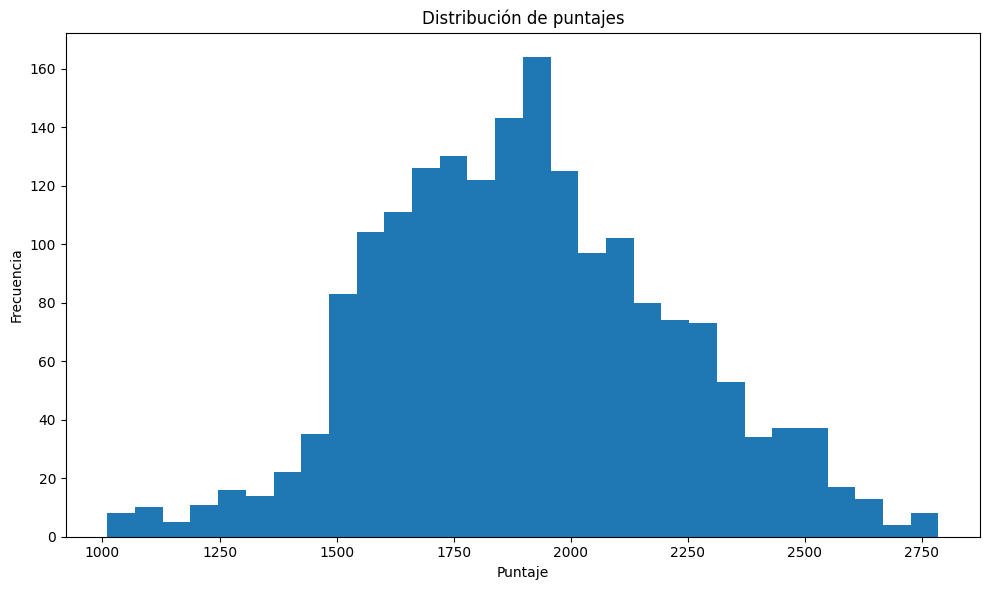

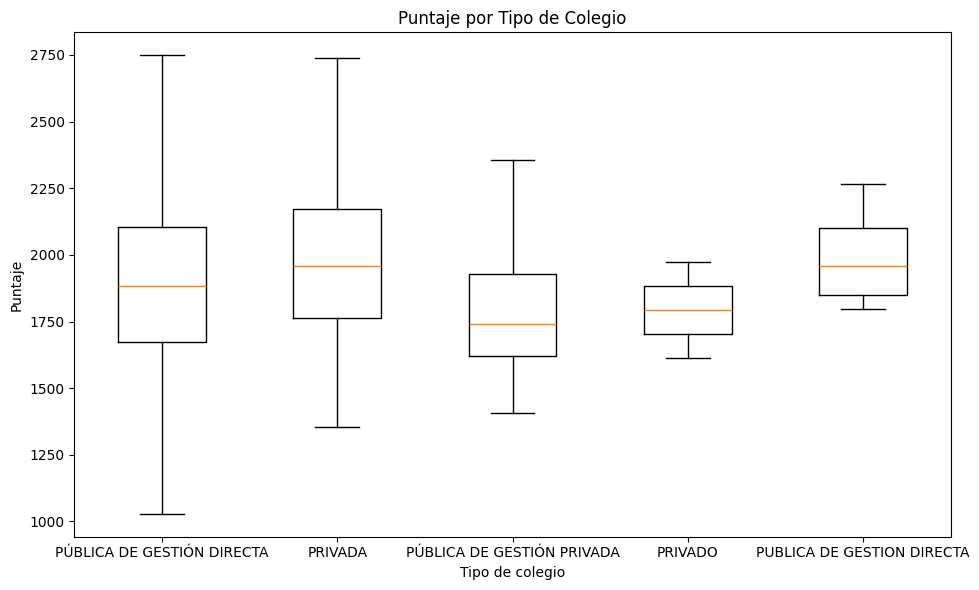

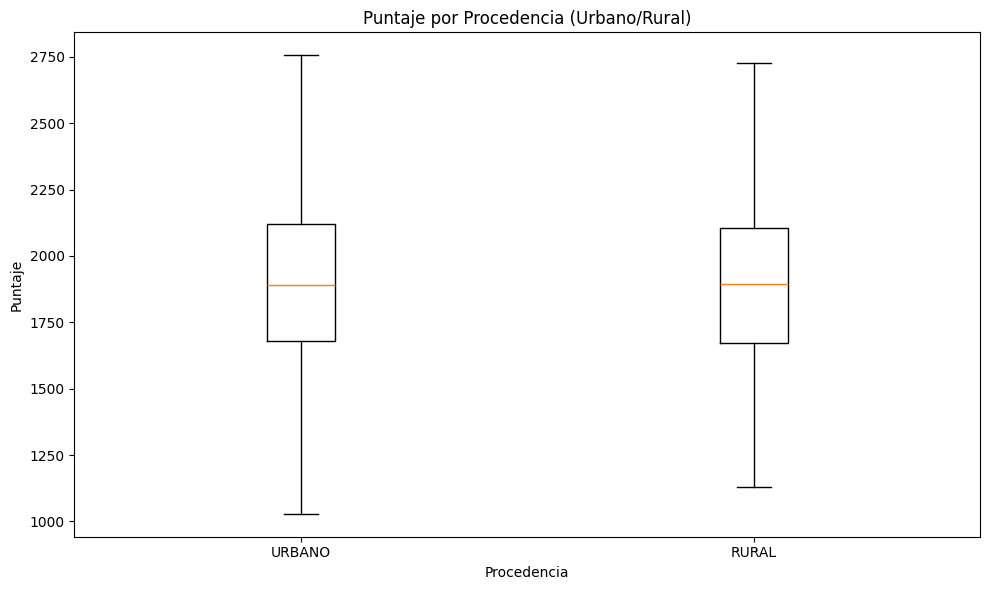

In [ ]:
import matplotlib.pyplot as plt

if 'PUNTAJE' in df.columns:
    plt.figure(figsize=(10,6)); plt.hist(df['PUNTAJE'].dropna(), bins=30)
    plt.title('Distribución de puntajes'); plt.xlabel('Puntaje'); plt.ylabel('Frecuencia')
    plt.tight_layout(); plt.savefig(OUT_DIR/'hist_puntaje.png', dpi=140); plt.show()

if 'TIPO_COLEGIO' in df.columns:
    grupos = list(df['TIPO_COLEGIO'].unique())
    data = [df.loc[df['TIPO_COLEGIO']==g, 'PUNTAJE'].dropna().values for g in grupos]
    plt.figure(figsize=(10,6)); plt.boxplot(data, labels=grupos, vert=True, showfliers=False)
    plt.title('Puntaje por Tipo de Colegio'); plt.xlabel('Tipo de colegio'); plt.ylabel('Puntaje')
    plt.tight_layout(); plt.savefig(OUT_DIR/'box_tipo_colegio.png', dpi=140); plt.show()

if 'PROC_URBANO' in df.columns:
    grupos = list(df['PROC_URBANO'].unique())
    data = [df.loc[df['PROC_URBANO']==g, 'PUNTAJE'].dropna().values for g in grupos]
    plt.figure(figsize=(10,6)); plt.boxplot(data, labels=grupos, vert=True, showfliers=False)
    plt.title('Puntaje por Procedencia (Urbano/Rural)'); plt.xlabel('Procedencia'); plt.ylabel('Puntaje')
    plt.tight_layout(); plt.savefig(OUT_DIR/'box_proc_urbano.png', dpi=140); plt.show()

6. Modelos de Regresión

,Modelo,R2_test,RMSE_test,MAE_test,R2_CV
3,XGBoost,0.565623,198.638309,143.921515,0.612392
1,RandomForest,0.545683,203.146458,141.836303,0.605812
2,GradientBoosting,0.513991,210.112504,159.152109,0.541363
0,Ridge,0.477139,217.933001,160.391701,0.530555


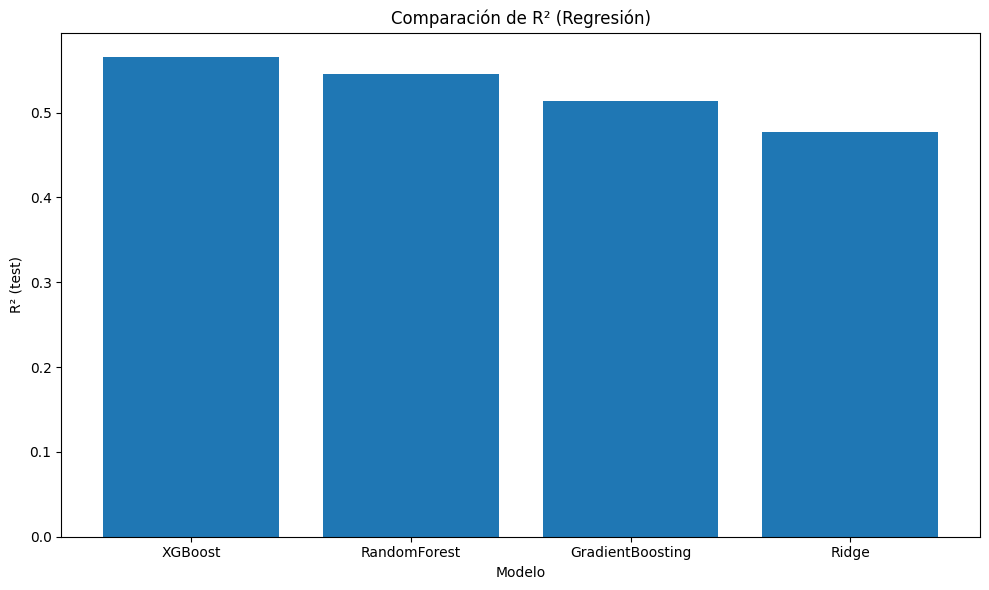

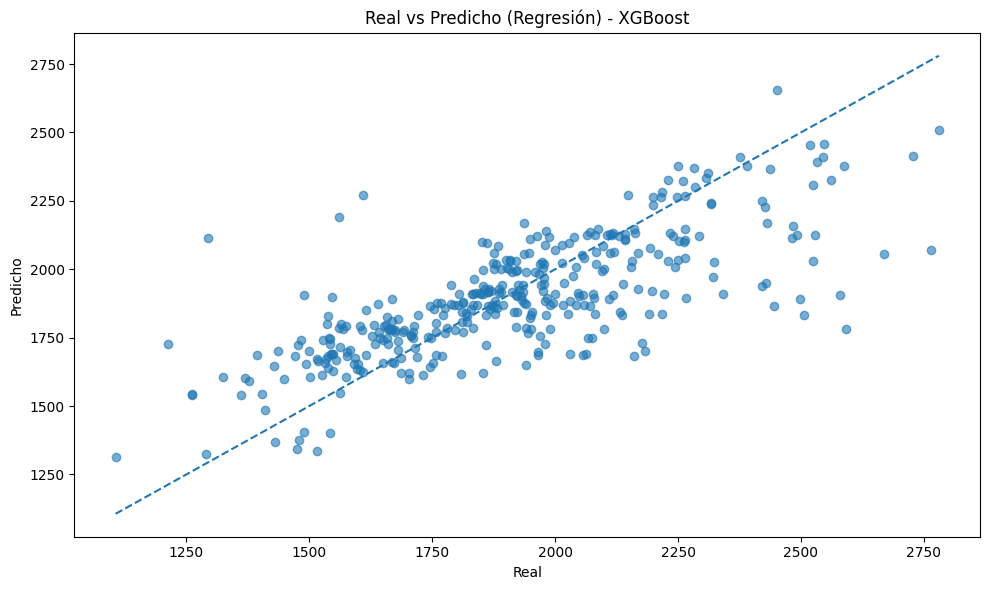

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
reg_models = {
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}
if HAS_XGB:
    reg_models['XGBoost'] = xgb.XGBRegressor(n_estimators=300, random_state=42, learning_rate=0.05)

X_tr, X_te, y_tr, y_te = train_test_split(X, y_reg, test_size=0.2, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rows=[]
for n,m in reg_models.items():
    cv = cross_val_score(m, X, y_reg, scoring='r2', cv=kf).mean()
    m.fit(X_tr,y_tr); pr = m.predict(X_te)
    rows.append({'Modelo':n,'R2_test':r2_score(y_te,pr),'RMSE_test':np.sqrt(mean_squared_error(y_te,pr)),'MAE_test':mean_absolute_error(y_te,pr),'R2_CV':cv})
reg_table = pd.DataFrame(rows).sort_values('R2_test', ascending=False); display(reg_table)
reg_table.to_csv(OUT_DIR/'resultados_regresion.csv', index=False)

plt.figure(figsize=(10,6)); plt.bar(reg_table['Modelo'], reg_table['R2_test'])
plt.title('Comparación de R² (Regresión)'); plt.xlabel('Modelo'); plt.ylabel('R² (test)')
plt.tight_layout(); plt.savefig(OUT_DIR/'regresion_metricas_r2.png', dpi=140); plt.show()

best_reg_name = reg_table.iloc[0]['Modelo']; best_reg = reg_models[best_reg_name]; best_reg.fit(X_tr,y_tr); yhat=best_reg.predict(X_te)
plt.figure(figsize=(10,6)); plt.scatter(y_te, yhat, alpha=0.6);
plt.plot([y_te.min(),y_te.max()],[y_te.min(),y_te.max()],'--');
plt.title(f'Real vs Predicho (Regresión) - {best_reg_name}'); plt.xlabel('Real'); plt.ylabel('Predicho')
plt.tight_layout(); plt.savefig(OUT_DIR/'regresion_dispersion.png', dpi=140); plt.show()

7. Modelos de Clasificación

,Modelo,AUC_test,F1,Precision,Recall,Brier
3,XGBoost,0.865071,0.638037,0.742857,0.559140,0.114599
2,GradientBoosting,0.844895,0.637500,0.761194,0.548387,0.118348
0,LogisticRegression,0.842332,0.594937,0.723077,0.505376,0.118454
1,RandomForest,0.833989,0.623188,0.955556,0.462366,0.124853


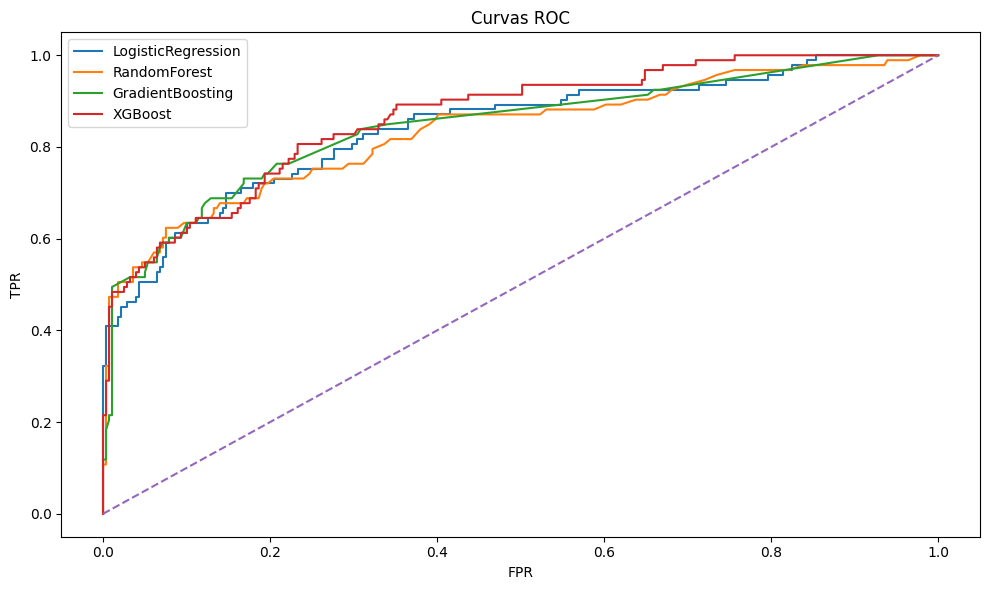

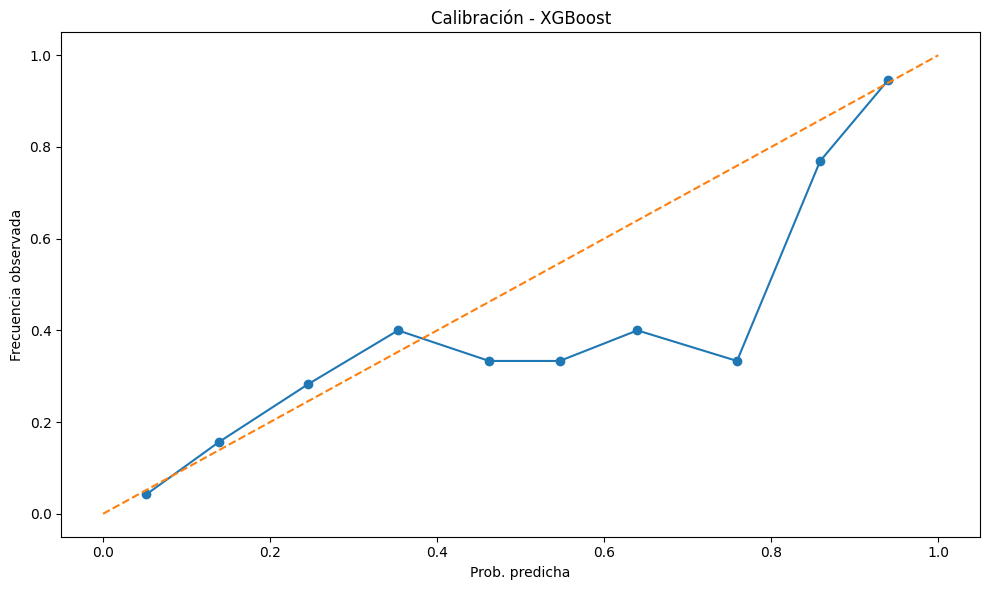

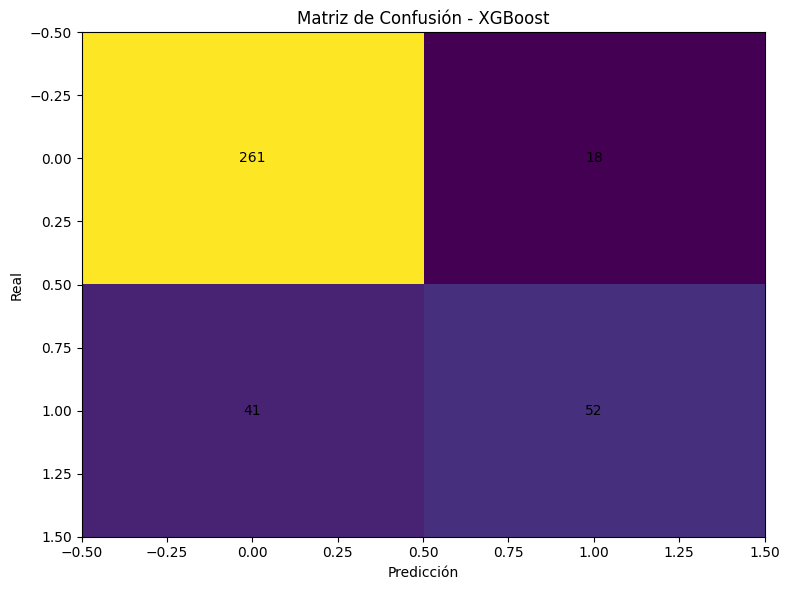

In [ ]:
clf_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),
    'RandomForest': RandomForestClassifier(n_estimators=500, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}
if HAS_XGB:
    clf_models['XGBoost'] = xgb.XGBClassifier(n_estimators=300, random_state=42, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss')

Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
rows=[]; roc_curves={}
for n,m in clf_models.items():
    m.fit(Xc_tr,yc_tr); proba=m.predict_proba(Xc_te)[:,1]; pred=(proba>=0.5).astype(int)
    fpr,tpr,_=roc_curve(yc_te, proba); roc_curves[n]=(fpr,tpr)
    rows.append({'Modelo':n,'AUC_test':roc_auc_score(yc_te,proba),'F1':f1_score(yc_te,pred),'Precision':precision_score(yc_te,pred),'Recall':recall_score(yc_te,pred),'Brier':brier_score_loss(yc_te,proba)})
clf_table = pd.DataFrame(rows).sort_values('AUC_test', ascending=False); display(clf_table)
clf_table.to_csv(OUT_DIR/'resultados_clasificacion.csv', index=False)

plt.figure(figsize=(10,6))
for n,(fpr,tpr) in roc_curves.items(): plt.plot(fpr,tpr,label=n)
plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Curvas ROC'); plt.legend()
plt.tight_layout(); plt.savefig(OUT_DIR/'roc_comparativa.png', dpi=140); plt.show()

best_clf_name = clf_table.iloc[0]['Modelo']; best_clf = clf_models[best_clf_name]
best_proba = best_clf.predict_proba(Xc_te)[:,1]; best_pred = (best_proba>=0.5).astype(int)
pt, pp = calibration_curve(yc_te, best_proba, n_bins=10, strategy='uniform')
plt.figure(figsize=(10,6)); plt.plot(pp, pt, marker='o'); plt.plot([0,1],[0,1],'--'); plt.xlabel('Prob. predicha'); plt.ylabel('Frecuencia observada'); plt.title(f'Calibración - {best_clf_name}')
plt.tight_layout(); plt.savefig(OUT_DIR/'calibracion.png', dpi=140); plt.show()

cm = confusion_matrix(yc_te, best_pred)
plt.figure(figsize=(8,6)); plt.imshow(cm, aspect='auto'); plt.title(f'Matriz de Confusión - {best_clf_name}'); plt.xlabel('Predicción'); plt.ylabel('Real')
import numpy as np
for (i,j),z in np.ndenumerate(cm): plt.text(j,i,str(z),ha='center',va='center')
plt.tight_layout(); plt.savefig(OUT_DIR/'confusion_matrix.png', dpi=140); plt.show()

8. Fairness

Grupo       TPR       PPR  \
Atributo                 Idx                                                   
SEXO                     0                     MASCULINO  0.580000  0.178404   
                         1                      FEMENINO  0.534884  0.201258   
PROC_URBANO              0                        URBANO  0.576923  0.196013   
                         1                         RURAL  0.466667  0.154930   
TIPO_COLEGIO             0    PÚBLICA DE GESTIÓN DIRECTA  0.561644  0.183607   
                         1                       PRIVADA  0.500000  0.206897   
                         2                       PRIVADO       NaN  0.000000   
                         3    PÚBLICA DE GESTIÓN PRIVADA  1.000000  0.333333   
                         4    PUBLICA DE GESTION DIRECTA       NaN  0.000000   
DEPARTAMENTO_PROCEDENCIA 0                          PUNO  0.586207  0.195402   
                         1                      AREQUIPA       NaN  0.200000   
                         2                         CUSCO  0.500000  0.090909   
                         3                           ICA  0.000000  0.000000   
                         4                          LIMA  0.000000  0.000000   
                         5                      APURÍMAC       NaN  0.000000   
                         6                         TACNA  0.000000  0.000000   
                         7                      MOQUEGUA  0.000000  0.000000   

                                n   TPR_gap   PPR_gap        DI       SPD  
Atributo                 Idx                                               
SEXO                     0    213  0.045116  0.022854  0.886444  0.022854  
                         1    159  0.045116  0.022854  0.886444  0.022854  
PROC_URBANO              0    301  0.110256  0.041084  0.790403  0.041084  
                         1     71  0.110256  0.041084  0.790403  0.041084  
TIPO_COLEGIO             0    305  0.500000  0.333333  0.000000  0.333333  
                         1     58  0.500000  0.333333  0.000000  0.333333  
                         2      2  0.500000  0.333333  0.000000  0.333333  
                         3      6  0.500000  0.333333  0.000000  0.333333  
                         4      1  0.500000  0.333333  0.000000  0.333333  
DEPARTAMENTO_PROCEDENCIA 0    348  0.586207  0.200000  0.000000  0.200000  
                         1      5  0.586207  0.200000  0.000000  0.200000  
                         2     11  0.586207  0.200000  0.000000  0.200000  
                         3      1  0.586207  0.200000  0.000000  0.200000  
                         4      3  0.586207  0.200000  0.000000  0.200000  
                         5      1  0.586207  0.200000  0.000000  0.200000  
                         6      2  0.586207  0.200000  0.000000  0.200000  
                         7      1  0.586207  0.200000  0.000000  0.200000

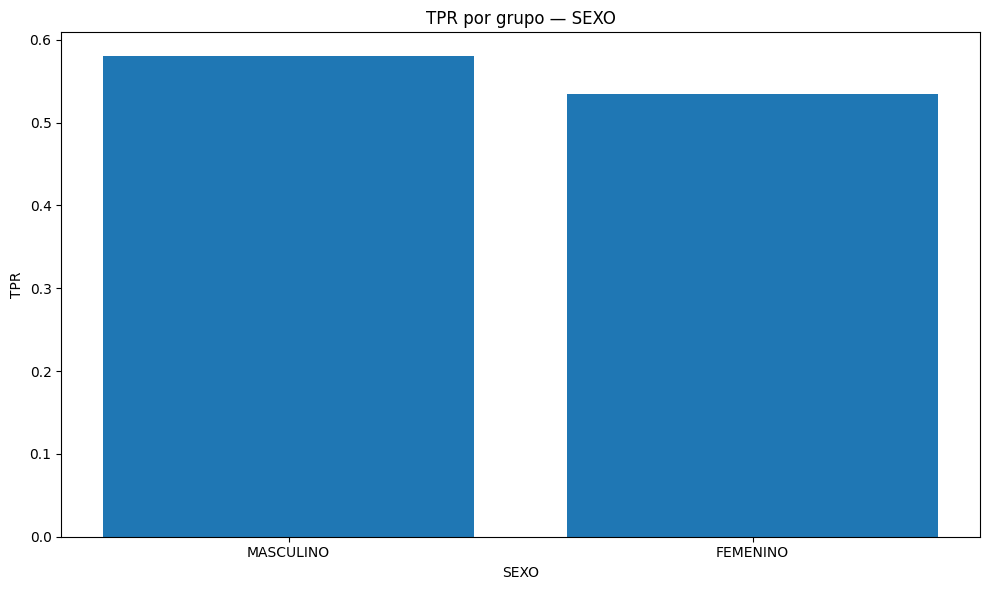

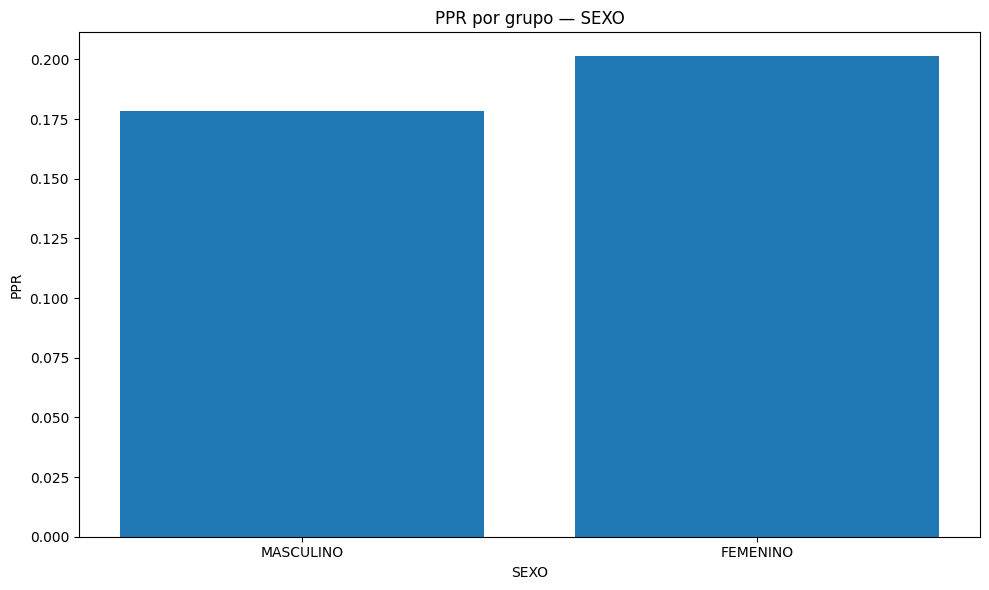

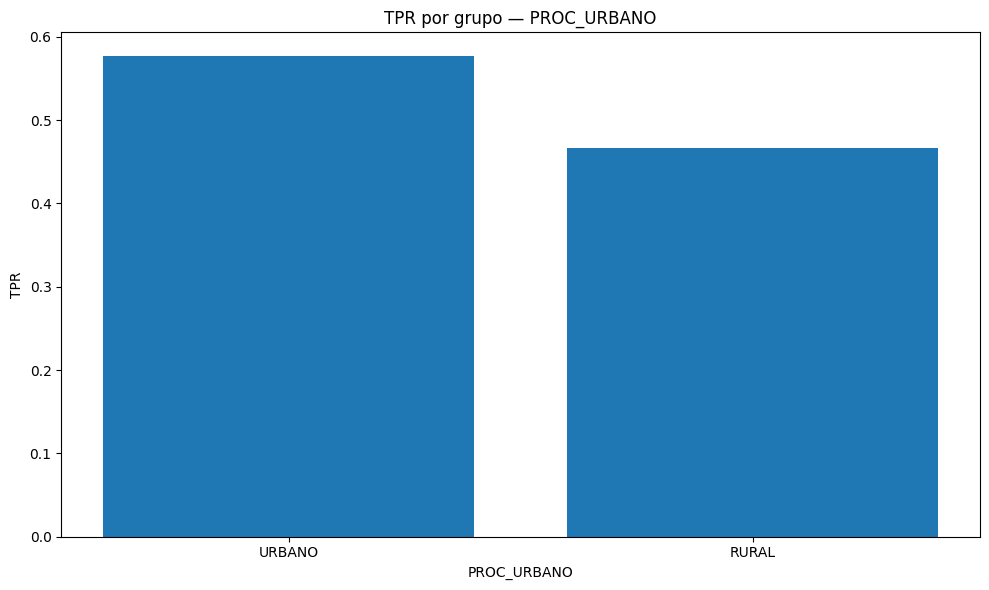

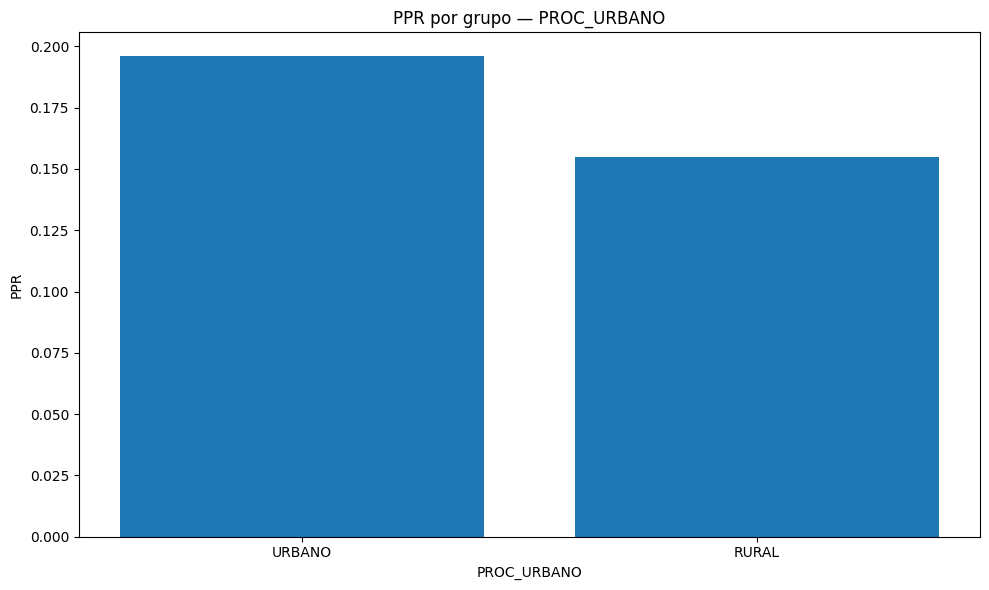

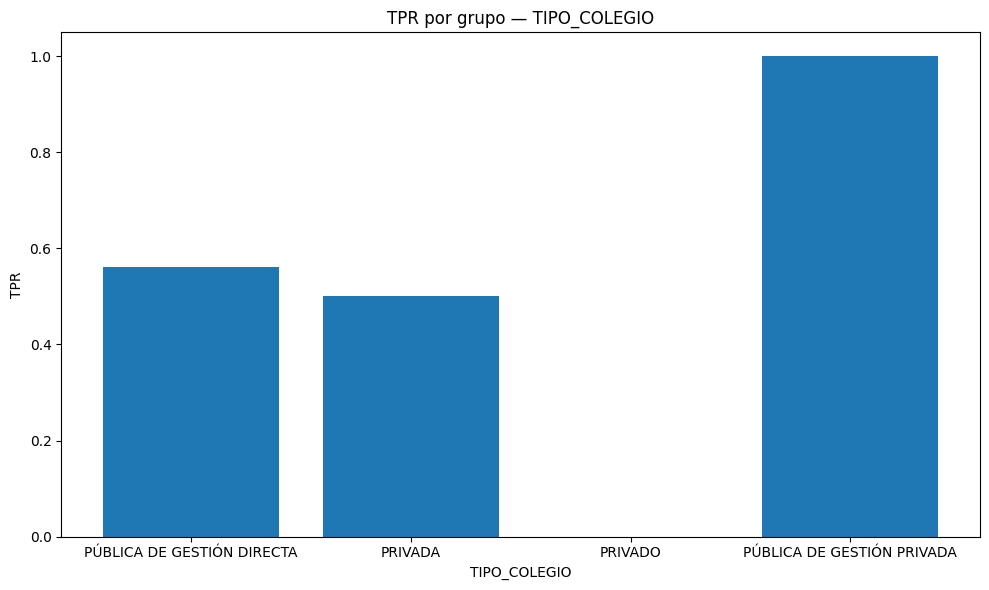

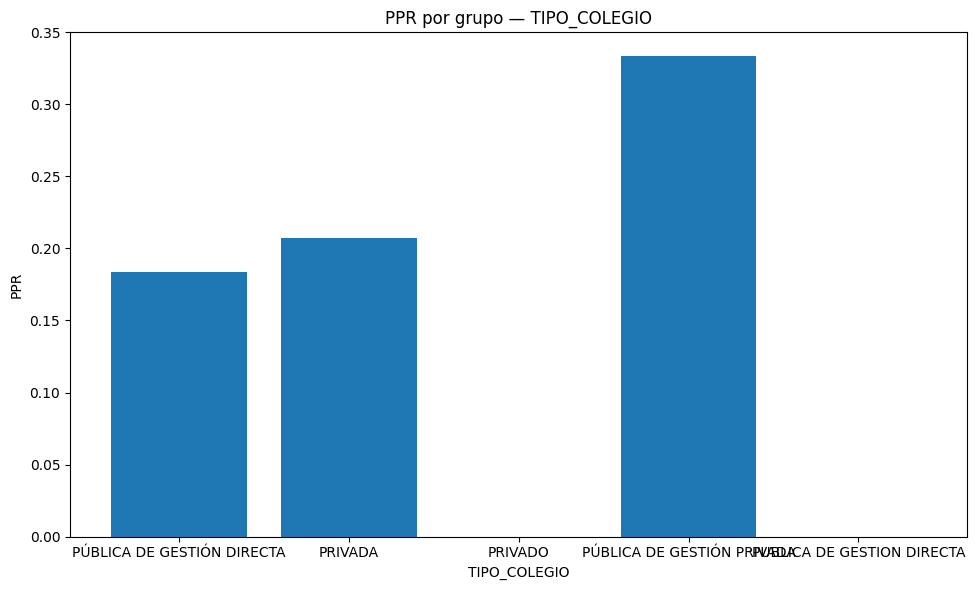

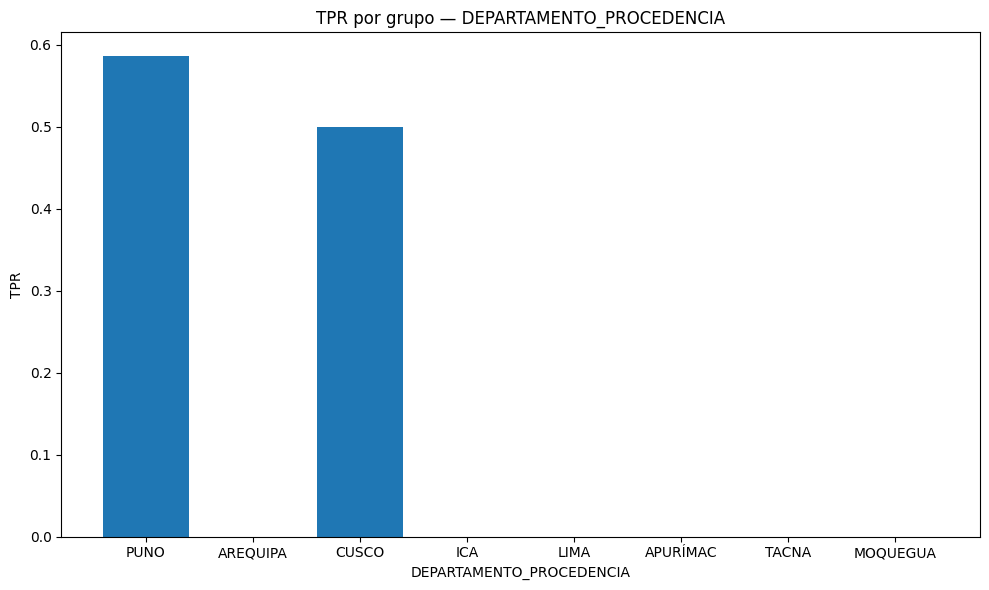

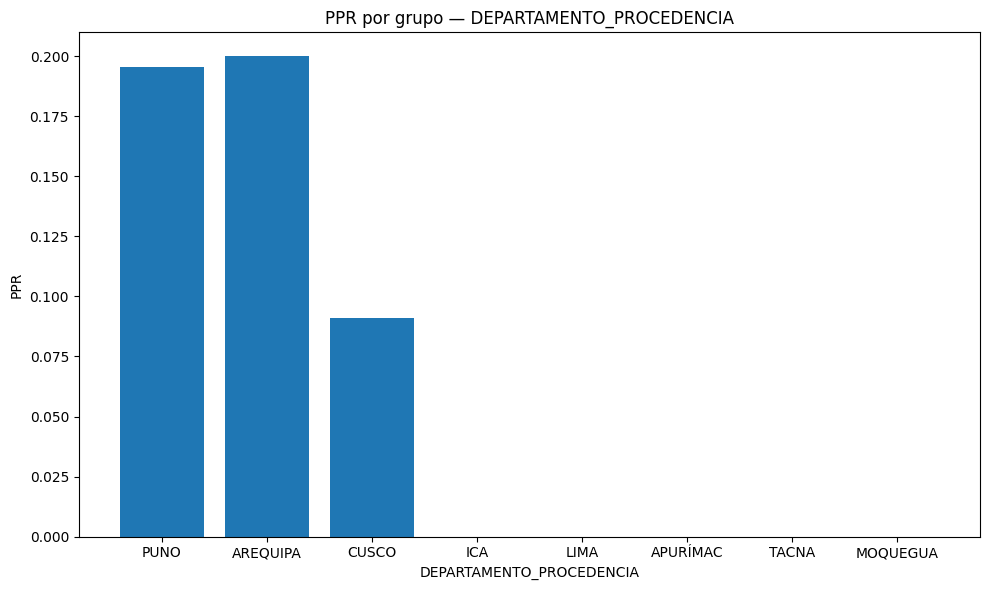

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def fairness_table(y_true, y_pred, group_series):
    rows=[]
    for g in pd.Series(group_series).dropna().unique():
        idx = (group_series==g)
        yt = y_true[idx]; yp = y_pred[idx]
        tp=int(((yt==1)&(yp==1)).sum()); fn=int(((yt==1)&(yp==0)).sum()); fp=int(((yt==0)&(yp==1)).sum()); tn=int(((yt==0)&(yp==0)).sum())
        tpr = tp/(tp+fn) if (tp+fn)>0 else np.nan
        ppr = float(yp.mean()) if len(yp)>0 else np.nan
        rows.append({'Grupo':str(g), 'TPR':tpr, 'PPR':ppr, 'n':int(idx.sum())})
    out = pd.DataFrame(rows)
    if not out.empty:
        out['TPR_gap'] = out['TPR'].max()-out['TPR'].min()
        out['PPR_gap'] = out['PPR'].max()-out['PPR'].min()
        adv = out['PPR'].max(); dis = out['PPR'].min()
        out['DI']  = dis/adv if adv and adv>0 else np.nan
        out['SPD'] = abs(adv-dis)
    return out

attrs = ['SEXO','PROC_URBANO','TIPO_COLEGIO','DEPARTAMENTO_PROCEDENCIA']
fair_dict = {}
for a in attrs:
    if a in df.columns:
        fair_dict[a] = fairness_table(yc_te.values, best_pred, df.loc[Xc_te.index, a])

if fair_dict:
    fair_all = pd.concat(fair_dict, names=['Atributo','Idx'])
    display(fair_all)
    fair_all.to_csv(OUT_DIR/'resultados_equidad.csv')
else:
    print("Sin atributos sensibles disponibles.")

for a,t in fair_dict.items():
    plt.figure(figsize=(10,6)); plt.bar(t['Grupo'], t['TPR']); plt.title(f'TPR por grupo — {a}'); plt.xlabel(a); plt.ylabel('TPR')
    plt.tight_layout(); plt.savefig(OUT_DIR/f'fairness_tpr_{a}.png', dpi=140); plt.show()
    plt.figure(figsize=(10,6)); plt.bar(t['Grupo'], t['PPR']); plt.title(f'PPR por grupo — {a}'); plt.xlabel(a); plt.ylabel('PPR')
    plt.tight_layout(); plt.savefig(OUT_DIR/f'fairness_ppr_{a}.png', dpi=140); plt.show()

9. Resumen Automático

In [ ]:
summary = []

best_reg = reg_table.iloc[0]
summary.append(f"[Regresión] Mejor: {best_reg['Modelo']} | R2_test={best_reg['R2_test']:.3f} | RMSE={best_reg['RMSE_test']:.2f}")

best_clf = clf_table.iloc[0]
summary.append(f"[Clasificación] Mejor: {best_clf['Modelo']} | AUC={best_clf['AUC_test']:.3f} | F1={best_clf['F1']:.3f} | Brier={best_clf['Brier']:.3f}")

import math
if 'fair_all' in locals():
    # Agregar la peor brecha observada entre atributos
    try:
        tpr_gaps = []; ppr_gaps = []; dis_list = []; spd_list = []
        for a,t in fair_dict.items():
            if 'TPR_gap' in t.columns: tpr_gaps.append(float(t['TPR_gap'].max()))
            if 'PPR_gap' in t.columns: ppr_gaps.append(float(t['PPR_gap'].max()))
            if 'DI' in t.columns: dis_list += list(t['DI'].dropna().values)
            if 'SPD' in t.columns: spd_list += list(t['SPD'].dropna().values)
        if tpr_gaps: summary.append(f"[Equidad] Máx TPR_gap={max(tpr_gaps):.3f}")
        if ppr_gaps: summary.append(f"[Equidad] Máx PPR_gap={max(ppr_gaps):.3f}")
        if dis_list: summary.append(f"[Equidad] Promedio DI={np.mean(dis_list):.3f}")
        if spd_list: summary.append(f"[Equidad] Promedio SPD={np.mean(spd_list):.3f}")
    except Exception:
        pass

summary.append(f"Recomendación: utilizar {best_clf['Modelo']} como referencia para clasificación de alto puntaje y monitorear brechas de equidad por subgrupos.")
print("\n".join(summary))


[Regresión] Mejor: XGBoost | R2_test=0.566 | RMSE=198.64
[Clasificación] Mejor: XGBoost | AUC=0.865 | F1=0.638 | Brier=0.115
[Equidad] Máx TPR_gap=0.586
[Equidad] Máx PPR_gap=0.333
[Equidad] Promedio DI=0.197
[Equidad] Promedio SPD=0.200
Recomendación: utilizar XGBoost como referencia para clasificación de alto puntaje y monitorear brechas de equidad por subgrupos.
